In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re


from nltk.corpus import gutenberg, stopwords
from collections import Counter

from sklearn import linear_model,neighbors, ensemble, svm
from sklearn.model_selection import train_test_split

%matplotlib inline

/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
            
        
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df
    


In [3]:
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')
emma = gutenberg.raw('austen-emma.txt')
moby = gutenberg.raw('melville-moby_dick.txt')
# The Chapter indicator is idiosyncratic

persuasion = re.sub(r'Chapter \d+', '', persuasion)

alice = re.sub(r'CHAPTER .*', '', alice)

emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)

moby = re.sub(r'VOLUME \w+', '', moby)
moby = re.sub(r'CHAPTER \w+', '', moby)

moby = text_cleaner(moby)
emma = text_cleaner(emma)    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [4]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)



In [5]:
persuasion_doc = nlp(persuasion)

In [6]:
emma_doc = nlp(emma)


In [7]:
moby_doc = nlp(moby[:500000])

In [149]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen1"] for sent in emma_doc.sents]
emma_sents = emma_sents[0:len(alice_sents)]
moby_sents = [[sent, "Melvile"] for sent in moby_doc.sents]
moby_sents = moby_sents[0:len(alice_sents)]


# Combine the sentences from the two novels into one data frame.
sentences0 = pd.DataFrame(alice_sents + persuasion_sents)
sentencesam = pd.DataFrame(alice_sents + moby_sents)
sentences2 = pd.DataFrame(moby_sents + emma_sents + persuasion_sents + alice_sents)
moby_df = pd.DataFrame(moby_sents)
emma_df = pd.DataFrame(emma_sents)

In [146]:
# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)
mobywords = bag_of_words(moby_doc)
emmawords = bag_of_words(emma_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords + mobywords + emmawords)



In [147]:
all_bow = bow_features(sentences2,common_words)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500


In [28]:
moby_bow = bow_features(moby_df,common_words)


Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


In [29]:
emma_bow = bow_features(emma_df,common_words)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500


In [34]:
moby_bow['sent_len'] = [len(i) for i in moby_df[0]]
emma_bow['sent_len'] = [len(i) for i in emma_df[0]]

In [151]:
all_bow['sent_len'] = [len(i) for i in sentences2[0]]

In [152]:
allposses = []
allposito = []
for i,sentence in enumerate(sentences2[0]):    
    pss = []
    for token in sentence:
        pss.append(token.pos_)
        allposses.append(token.pos_)
    allposito.append(pss)
#Create df for posses
allposses_df = pd.DataFrame(columns=set(allposses))
allposses_df['poss'] = allposito
allposses_df.loc[:, allposses] = 0

In [153]:
#turn poss counts into features
for i, sentence in enumerate(allposses_df['poss']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = allposses_df.poss[i]
        
        # Populate the row with word counts.
        for word in words:
            allposses_df.loc[i, word] += 1

In [154]:
# lets add people??
peoplea = [entity.text for entity in list(alice_doc.ents) if entity.label_ == "PERSON"]
peoplep = [entity.text for entity in list(persuasion_doc.ents) if entity.label_ == "PERSON"]
peoplee = [entity.text for entity in list(emma_doc.ents) if entity.label_ == "PERSON"]
peoplem = [entity.text for entity in list(moby_doc.ents) if entity.label_ == "PERSON"]
#combine the sets of 'people'


In [155]:
persons = set.union(*[set(peoplep),set(peoplea),set(peoplee),set(peoplem)])

In [156]:
#Create df for moby people
apeople = pd.DataFrame(columns=persons)
apeople['text_sentence'] = sentences2[0]
apeople['text_source']= sentences2[1]
apeople.loc[:, persons] = 0
apeople.head()
#turn poss counts into features
for i, sentence in enumerate(apeople['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = apeople['text_sentence'][i]
        # Populate the row with word counts.
        for word in words:
            if str(word) in persons:           
                apeople.loc[i, str(word)] += 1

In [157]:
all_final = pd.concat([all_bow.drop(['text_sentence'],1),
                  allposses_df.drop(['poss'],1).reset_index(drop=True),
                  apeople.drop(['text_sentence','text_source'],1
                             ).reset_index(drop=True)],axis=1)

In [162]:
all_final.text_source.value_counts()

Austen     3649
Carroll    1669
Melvile    1669
Austen1    1669
Name: text_source, dtype: int64

In [165]:
pers = all_final[all_final['text_source']== 'Austen']
emma = all_final[all_final['text_source']== 'Austen1']
moby = all_final[all_final['text_source']== 'Melvile']
alice = all_final[all_final['text_source']== 'Carroll']

## Challange 1. Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work

In [166]:
#train the model again with new words and people and pos
ali_pers = pd.concat([pers,alice],axis=0)

In [169]:
X = ali_pers.drop(['text_source'],axis=1)
y = ali_pers['text_source']

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4,
                                                    random_state=43)

In [175]:
lrc = linear_model.LogisticRegression(C=.40)
lrc.fit(X_train,y_train)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [176]:
print('Training set score:', lrc.score(X_train, y_train))
print('\nTest set score:', lrc.score(X_test, y_test))

Training set score: 0.9457680250783699

Test set score: 0.9046052631578947


In [177]:
svc = svm.SVC(kernel='linear',C=0.35)
svc.fit(X_train,y_train)

SVC(C=0.35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [178]:
print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

Training set score: 0.9608150470219435

Test set score: 0.9046052631578947


In [168]:
alice.shape,pers.shape

((1669, 5096), (3649, 5096))

In [ ]:
Alice vs Moby Dick

In [ ]:
#I will separate my data bit differently than the curriculum as it seems,
#only half legit. This is like 3/4 legit.

In [189]:
#Alice in Wonderland vs any other work
xdf = pd.DataFrame(X_test).reset_index(drop=True)
xdf['text_source'] = [ i for i in y_test ]
alice_test = xdf[xdf['text_source'] == 'Carroll']
A_M_test = pd.concat([alice_test.drop(['text_source'],1),moby.drop(['text_source'],1)],axis=0)
yam_test = pd.concat([alice_test.text_source,moby.text_source],axis=0)
A_M_test['text_source'] = yam_test
A_M_test.head()

In [203]:
X = A_M_test.drop(['text_source'],1)
y = A_M_test.text_source

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3,random_state=43)

In [204]:
y_pred = svc.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

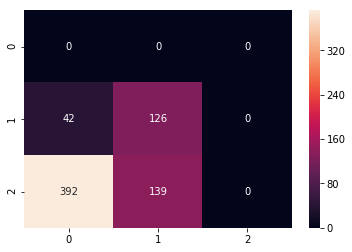

              precision    recall  f1-score   support

      Austen       0.00      0.00      0.00         0
     Carroll       0.48      0.75      0.58       168
     Melvile       0.00      0.00      0.00       531

   micro avg       0.18      0.18      0.18       699
   macro avg       0.16      0.25      0.19       699
weighted avg       0.11      0.18      0.14       699



/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true',

In [206]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d')
plt.show()
print(classification_report(y_test,y_pred))

In [210]:
#looks pretty bad
#lets do a multclass problem

X = all_final.drop(['text_source'],1)
y = all_final.text_source

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=43)

In [212]:
svc = svm.SVC(kernel='linear',C=0.35)
svc.fit(X_train,y_train)

SVC(C=0.35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [213]:
print(svc.score(X_test,y_test))
y_pred = svc.predict(X_test)

0.7516604100490903


              precision    recall  f1-score   support

      Austen       0.69      0.91      0.78      1458
     Austen1       0.79      0.52      0.62       637
     Carroll       0.86      0.73      0.79       709
     Melvile       0.83      0.65      0.73       659

   micro avg       0.75      0.75      0.75      3463
   macro avg       0.79      0.70      0.73      3463
weighted avg       0.77      0.75      0.75      3463



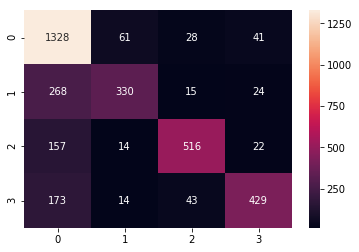

In [214]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [217]:
lrcm = linear_model.LogisticRegression(multi_class='multinomial',max_iter=250,C=0.35,solver='lbfgs')
lrcm.fit(X_train,y_train)

/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.35, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=250, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [220]:
print(lrcm.score(X_test,y_test))
y_pred = lrcm.predict(X_test)

0.7533930118394455


              precision    recall  f1-score   support

      Austen       0.71      0.90      0.79      1458
     Austen1       0.74      0.53      0.62       637
     Carroll       0.84      0.73      0.78       709
     Melvile       0.82      0.68      0.74       659

   micro avg       0.75      0.75      0.75      3463
   macro avg       0.78      0.71      0.73      3463
weighted avg       0.76      0.75      0.75      3463



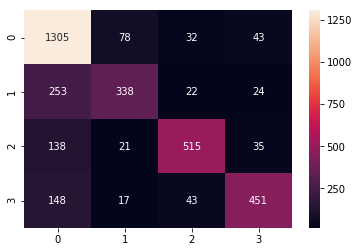

In [219]:
print(classification_report(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d')

In [ ]:
#super cool